<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture06/notebooks/L06_ConvAE_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional autoencoder


Let's create simplest autoencoder for MNIST!


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

Define training parameters and check if the GPU is available:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 30

The following function will load the MNIST dataset and apply specified transforms to it. It will also split it into train/test datasets.

In [ ]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

Now let's load the dataset and define dataloaders for train and test:

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4361535.27it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 63636.33it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 245548.69it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10084980.82it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
def plotn(n, data, noisy=False, super_res=None):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28) if z[0].shape[1] == 28 else z[0].reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0]
        if super_res is not None:
            _transform = transforms.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
            preprocess = _transform(preprocess)

        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)

        ax[i].imshow(preprocess[0])
    plt.show()

In [ ]:
def noisify(shapes):
    return np.random.normal(loc=0.5, scale=0.3, size=shapes)

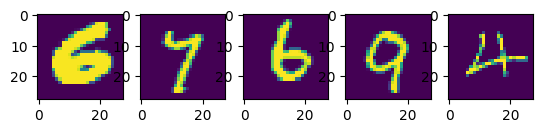

In [ ]:
plotn(5, train_dataset)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        return encoded

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        if not super_resolution:
            self.encoder = Encoder()
        else:
            self.encoder = SuperResolutionEncoder()
        self.decoder = Decoder()

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [ ]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device, noisy=None, super_res=None):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            shapes = list(imgs.shape)

            if super_res is not None:
                shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                _transform = transforms.Resize((shapes[2], shapes[3]))
                imgs_transformed = _transform(imgs)
                imgs_transformed = imgs_transformed.to(device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            if noisy is not None:
                noisy_tensor = noisy[0]
            else:
                noisy_tensor = torch.zeros(tuple(shapes)).to(device)

            if super_res is None:
                imgs_noisy = imgs + noisy_tensor
            else:
                imgs_noisy = imgs_transformed + noisy_tensor

            imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

            preds = model(imgs_noisy)
            loss = loss_fn(preds, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                shapes = list(imgs.shape)

                if super_res is not None:
                    shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                    _transform = transforms.Resize((shapes[2], shapes[3]))
                    imgs_transformed = _transform(imgs)
                    imgs_transformed = imgs_transformed.to(device)


                imgs = imgs.to(device)
                labels = labels.to(device)

                if noisy is not None:
                    test_noisy_tensor = noisy[1]
                else:
                    test_noisy_tensor = torch.zeros(tuple(shapes)).to(device)

                if super_res is None:
                    imgs_noisy = imgs + test_noisy_tensor
                else:
                    imgs_noisy = imgs_transformed + test_noisy_tensor

                imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

                preds = model(imgs_noisy)
                loss = loss_fn(preds, imgs)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [ ]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [07:43<00:00, 15.45s/it, train loss:=0.104, test loss:=0.104]


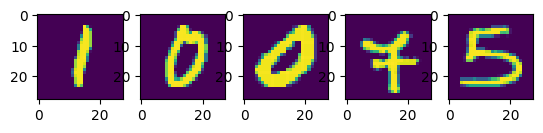

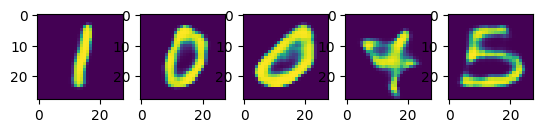

In [ ]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

> **Task 1**: Try to train autoencoder with very small latent vector size, eg. 2, and plot the dots corresponding to different digits. *Hint: Use fully-connected dense layer after the convoluitonal part to reduce the vector size to the required value.*

> **Task 2**: Starting from different digits, obtain their latent space representations, and see what effect adding some noise to the latent space has on the resulting digits.

> **Task 3**: How and why is BCELoss used in the training of autoencoders, particularly when dealing with binary or probabilistic outputs?

> **Task 4**: In the context of a convolutional autoencoder (conv2d AE), how do the downsampling and upsampling procedures work, and why are they important for the reconstruction process?

## Denoising

Autoencoders can be effectively used to remove noise from images. In order to train denoiser, we will start with noise-free images, and add artificial noise to them. Then, we will feed autoencoder with noisy images as input, and noise-free images as output.

Let's see how this works for MNIST:

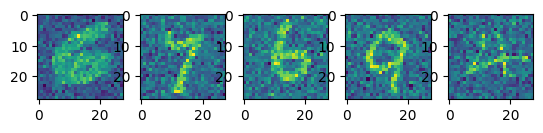

In [ ]:
plotn(5, train_dataset, noisy=True)

In [ ]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [ ]:
noisy_tensor = torch.FloatTensor(noisify([256, 1, 28, 28])).to(device)
test_noisy_tensor = torch.FloatTensor(noisify([1, 1, 28, 28])).to(device)
noisy_tensors = (noisy_tensor, test_noisy_tensor)

In [ ]:
train(dataloaders, model, loss_fn, optimizer, 100, device, noisy=noisy_tensors)

100%|██████████| 100/100 [25:20<00:00, 15.20s/it, train loss:=0.115, test loss:=0.116]


In [ ]:
model.eval()
predictions = []
noise = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    shapes = data[0].shape
    noisy_data = data[0] + test_noisy_tensor[0].detach().cpu()
    noise.append(noisy_data)
    predictions.append(model(noisy_data.to(device).unsqueeze(0)).detach().cpu())
plotn(plots, noise)
plotn(plots, predictions)

> **Exercise:** See how denoiser trained on MNIST digits works for different images. As an example, you can take [Fashion MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) dataset, which has the same image size. Note that denoiser works well only on the same image type that it was trained on (i.e. for the same probability distribution of input data).

## Super-Resolution

Similarly to denoiser, we can train autoencoders to increase the resolution of the image. To train super-resolution network, we will start with high-resolution images, and automatically downscale them to produce network inputs. We will then feed autoencoder with small images as inputs and high-resolution images as outputs.

For that let's downscale image to 14x14 at train.

In [ ]:
super_res_koeff = 2.0
plotn(5, train_dataset, super_res=super_res_koeff)

In [ ]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        encoded = self.maxpool2(self.relu(self.conv2(hidden1)))
        return encoded

In [ ]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        encoded = self.maxpool2(self.relu(self.conv2(hidden1)))
        return encoded

In [ ]:
train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=2.0)

In [ ]:
model.eval()
predictions = []
plots = 5
shapes = test_dataset[0][0].shape

for i, data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
    predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)

> **Exercise**: Try to train super-resolution network on [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) for 2x and 4x upscaling. Use noise as input to 4x upscaling model and observe the result.